In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import dask.dataframe as dd

In [2]:
os.chdir('E:\personal project\Lending Club')

In [3]:
#dff = dd.read_csv('LoanStats_2015.csv',dtype='str')
#dff.loan_status.value_counts().compute()
#df=dff[dff.loan_status.isin(['Fully Paid','Charged Off','Late (31-120 days),','Default','In Grace Period','Late (16-30 days)'])].compute()
#df.reset_index(inplace=True,drop=True)

In [4]:
#df.to_csv('LoanStats_2015_nocurrent.csv',index=False)

In [5]:
df = pd.read_csv('LoanStats_2015_nocurrent.csv',dtype='str',encoding='latin-1')

In [6]:
df.shape

(249633, 145)

In [7]:
delete_col=df.isnull().sum()[df.isnull().sum()/len(df)>0.5].index.tolist()

In [8]:
df.drop(delete_col,inplace=True,axis=1)

In [9]:
# variables will not be used for applications model
not_used_cols=['funded_amnt','funded_amnt_inv','issue_d','pymnt_plan','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
'collections_12_mths_ex_med','policy_code','delinq_amnt','hardship_flag','debt_settlement_flag','last_credit_pull_d']

In [10]:
df.drop(not_used_cols,inplace=True,axis=1)

In [11]:
df.shape

(249633, 67)

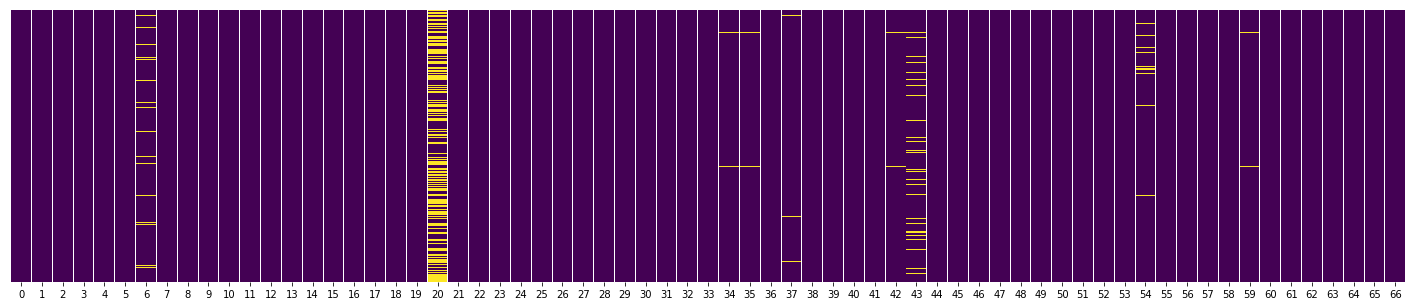

In [12]:
plt.figure(figsize=(25,5)) 
sns.set_context(font_scale=10)   
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',xticklabels=list(range(len(df.columns))))

In [13]:
df.isnull().sum()[df.isnull().sum()>0]

emp_title                  13709
title                         65
dti                            2
mths_since_last_delinq    120457
revol_util                   110
bc_open_to_buy              2531
bc_util                     2707
mo_sin_old_il_acct          6782
mths_since_recent_bc        2422
mths_since_recent_inq      22490
num_rev_accts                  1
num_tl_120dpd_2m           11441
percent_bc_gt_75            2699
dtype: int64

In [14]:
# remove units
df.int_rate=df.int_rate.str[:-1]
df.revol_util=df.revol_util.str[:-1]
df.term=df.term.str[:3]

df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')]=df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')].str[:-6]
df.emp_length[df.emp_length=='< 1 year']=df.emp_length[df.emp_length=='< 1 year'].str[:-5]
df.emp_length[df.emp_length=='1 year']=df.emp_length[df.emp_length=='1 year'].str[:-5]
df.emp_length[df.emp_length=='10+ years']=df.emp_length[df.emp_length=='10+ years'].str[:-7]
# '<1 year'-->0, '10+ years'-->10
df.emp_length[df.emp_length=='< 1']=0
df.emp_length[df.emp_length=='']=np.nan

# keep first 3 digit of zipcode
df.zip_code=df.zip_code.str[:-2]

In [15]:
# good loans(0) and bad loan(1) 
df.loan_status.value_counts()

Fully Paid           183593
Charged Off           62042
In Grace Period        2943
Late (16-30 days)      1033
Default                  22
Name: loan_status, dtype: int64

In [16]:
# good loans(0) and bad loan(1) 
df['label']='0'
df.loc[df.loan_status.isin(['Charged Off','Late (16-30 days)','Default']),'label']='1'

In [17]:
df.label.value_counts()

0    186536
1     63097
Name: label, dtype: int64

In [18]:
# transform date into duration (in years)
earl_d=df.earliest_cr_line
earl_y=[datetime.strptime(x,'%m/%d/%Y').year for x in earl_d]
dur_y=np.repeat(2015,len(earl_y))-earl_y

In [19]:
df['dur_y']=dur_y

In [20]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'nu

In [21]:
df.fillna(-999,inplace=True)

In [22]:
l_int=['loan_amnt','term','emp_length','zip_code','delinq_2yrs','inq_last_6mths',
      'mths_since_last_delinq','open_acc','pub_rec','revol_bal','total_acc','acc_now_delinq','tot_coll_amt',
      'tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal', 'bc_open_to_buy','chargeoff_within_12_mths', 
       'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl','mort_acc', 
       'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl','num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
       'num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m','pub_rec_bankruptcies','tax_liens', 
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','total_il_high_credit_limit','dur_y']
l_float=['int_rate','annual_inc','installment','dti','revol_util','bc_util','pct_tl_nvr_dlq', 'percent_bc_gt_75']
l_object=['grade', 'sub_grade', 'emp_title', 'home_ownership','verification_status', 'loan_status', 'purpose', 'title', 
          'addr_state','earliest_cr_line', 'initial_list_status', 'application_type','disbursement_method', 'label']

In [23]:
for i in l_int:
    df[i]=df[i].astype(int)
for i in l_float:
    df[i]=df[i].astype(float)
for i in l_object:
    df[i]=df[i].astype(object)

In [24]:
len(l_float)+len(l_int)+len(l_object)

69